In [58]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit.tools.visualization import plot_bloch_multivector
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, execute
from qiskit import QuantumCircuit, Aer, execute, IBMQ
import import_ipynb
import circuitgenerator as circ
import operator

In [18]:
results = {'000': 2783, '001': 1240, '100': 603, '111': 815, '110': 294, '010': 1712, '101': 485, '011': 260}

results_maxtomin = {'000': 2783, '010': 1712, '001': 1240, '111': 815, '100': 603, '101': 485, '110': 294, '011': 260}

graph = {'StayAtHome': ([], [0.645, 0.355]), 'Testing': ([], [0.62, 0.38]), 'Cases': (['StayAtHome', 'Testing'], [0.8181818181818182, 0.18181818181818182, 0.8412698412698413, 0.15873015873015872, 0.7068965517241379, 0.29310344827586204, 0.23076923076923078, 0.7692307692307693])}



In [69]:
def determine_color(state):
    if state == '0':
        color='red'
    elif state=='1':
        color='green'
    elif state=='2':
        color='forestgreen'
    elif state=='3':
        color='darkgreen'
    return color

def make_counts_hist(counts_results):
    probabilities = np.array([counts_results[k] for k in counts_results]) / sum(counts_results.values())
    print(probabilities)
    plt.bar(list(counts_results.keys()), counts_results.values())
    plt.ylabel('Counts')    
    plt.xticks(list(counts_results.keys()), [None])
    xpos_text = -0.3
    for key in counts_results:
        Cstate=key[0]
        Bstate=key[1]
        Astate=key[2]
        Ccolor, Bcolor, Acolor = determine_color(Cstate, Bstate, Astate)
        plt.text(xpos_text, -200,'Cases', color=Ccolor)
        plt.text(xpos_text, -400, 'Tests', color=Bcolor)
        plt.text(xpos_text, -600,'Home', color=Acolor)
        xpos_text += 1
    plt.show()
    return

def get_marginal_probabilities(state_counts, whichstate=0):
    #state_counts: dict, counts for each state from network result (should have 2^n entries)
    #whichstate: integer representing the state that you want the marginal probability of (for a 2-state system this
        #could be 0 or 1).
    #marg_probs: array of length n, marginal probabilities that each qubit is whichstate,
        #from most significant to least significant qubit
    
    n = len(list(state_counts.keys())[0]) #number of qubits
    prob = np.zeros(n)
    total = sum(state_counts.values())

    for i in range(n):
        for key in state_counts:
            if int(key[i]) == whichstate:
                prob[i] += state_counts[key]
        prob[i] = prob[i]/total
    
    return prob

def make_prob_hist(counts_results, var_labels, top_n_probs='all', whichvar=['all',2,[]]):
    """
    INPUTS: counts_results: dictionary from circuitgenerator where keys are multi-qubit states and values are counts
            var_labels: IF WHICHVAR[0] = 'all': list of strings of variable names. Order of variable names in var_labels needs to be the same
                as the order of variables in a multi-qubit state in counts_results
                IF WHICHVAR[0] is not 'all': list of strings of state names for the variable chosen in whichvar
            top_n_probs: optional. So that you can make a histogram of n most likely probabilities. Default='all'. 
                Change to integer if you only want top n
            whichvar: list- first entry integer giving index of the variable in a key of counts_results that you want to marginal 
            probabilities for. Default='all' includes all variables and doesn't calculate marginal probabilities.
            Second entry is the number of states that variable can be in. Default is 2 states.
            Third entry is a list of the 
    """
    counts_results = dict(sorted(counts_results.items(), key=operator.itemgetter(1),reverse=True)) #sorts dictionary by decreasing counts
    probabilities = np.array([counts_results[k] for k in counts_results]) / sum(counts_results.values())
    #plt.bar(list(counts_results.keys()), probabilities)
    
    if (top_n_probs == 'all') & (whichvar[0] == 'all'):
        plt.bar(np.arange(len(counts_results)), probabilities)
        plt.ylabel('Probability')
        plt.xticks(np.arange(len(counts_results)), [None])
        xpos_text = -0.3
        for key in counts_results:
            for i in range(len(key)):
                state=key[i]
                color = determine_color(state)
                plt.text(xpos_text, -0.03-0.02*i,var_labels[i], color=color)
            xpos_text += 1
        plt.show()
    elif (top_n_probs != 'all') & (whichvar[0] == 'all'):
        plt.bar(np.arange(top_n_probs), probabilities[0:top_n_probs])
        plt.ylabel('Probability')
        plt.xticks(np.arange(top_n_probs), [None])
        xpos_text = -0.3
        counter = 0
        for key in counts_results:
            if counter < top_n_probs:
                for i in range(len(key)):
                    state=key[i]
                    color = determine_color(state)
                    plt.text(xpos_text, -0.03-0.02*i,var_labels[i], color=color)
                xpos_text += 1
                counter += 1
        plt.show()
        
    elif (top_n_probs == 'all') & (whichvar[0] != 'all'):
        pvar = []
        for i in range(whichvar[1]):
            pvar.append(get_marginal_probabilities(counts_results, whichstate=i)[whichvar[0]])
        plt.bar(np.arange(whichvar[1]), pvar)
        plt.ylabel('Probability')
        plt.xticks(np.arange(whichvar[1]), [None])
        xpos_text = -0.3
        for i in range(len(pvar)):
            state = i
            color = determine_color(str(state))
            plt.text(xpos_text, -0.07,var_labels[i], color=color)
            xpos_text += 1
        plt.show()
        
    elif (top_n_probs != 'all') & (whichvar[0] != 'all'):
        pvar = []
        for i in range(whichvar[1]):
            pvar.append(get_marginal_probabilities(counts_results, whichstate=i)[whichvar[0]])
        numbars = min(whichvar[1], top_n_probs)
        plt.bar(np.arange(numbars), pvar)
        plt.ylabel('Probability')
        plt.xticks(np.arange(numbars), [None])
        xpos_text = -0.3
        for i in range(numbars):
            state = i
            color = determine_color(str(state))
            plt.text(xpos_text, -0.07,var_labels[i], color=color)
            xpos_text += 1
        plt.show()
    return
        


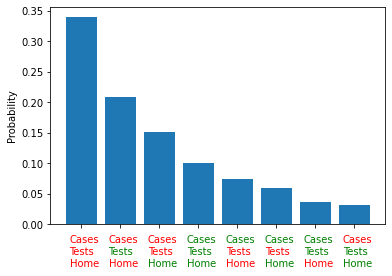

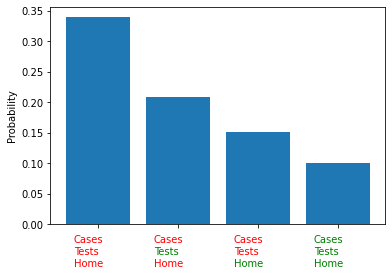

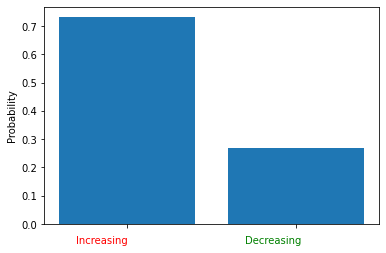

In [70]:
"""examples"""

var_labels = ['Cases', 'Tests', 'Home']

make_prob_hist(results, var_labels, top_n_probs='all')       
make_prob_hist(results, var_labels, top_n_probs=4)        
make_prob_hist(results_maxtomin, ['Increasing','Decreasing'], top_n_probs='all', whichvar=[0,2])  



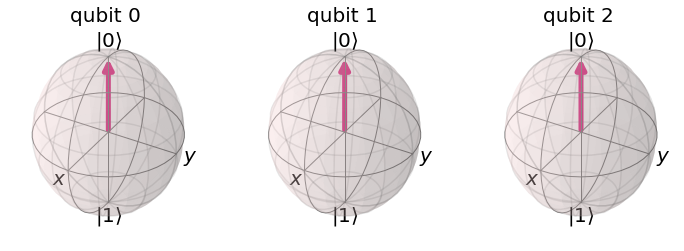

In [9]:
"""Lesser model before rotation - for presentation"""
q = QuantumRegister(3)
qc = QuantumCircuit(q)

qc.id(0)

simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, backend=simulator).result()
statevector = result.get_statevector()

plot_bloch_multivector(statevector)


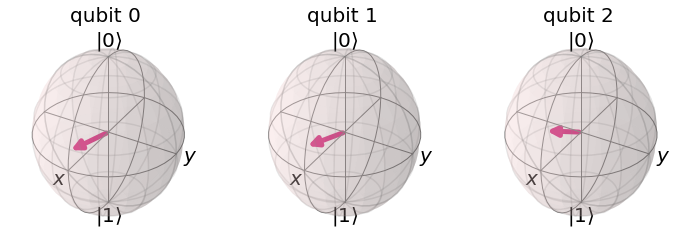

In [12]:
"""Lesser model after rotation - for presentation"""
q = QuantumRegister(3)
qc = QuantumCircuit(q)

qc.ry(circ.angle_from_probability(.62,.38), 0)
qc.ry(circ.angle_from_probability(0.645,0.355), 1)
qc.ry(circ.angle_from_probability(0.73,0.27),2)

simulator = Aer.get_backend('statevector_simulator')
result = execute(qc, backend=simulator).result()
statevector = result.get_statevector()

plot_bloch_multivector(statevector)